# Assignment 4
**Group 5**

Group members:
- Moqian Chen (r0965473)
- Laurens Dergent (r0794288)
- Sarah Guilliams (r0751825)
- Yeabsera Kinfu (r0930148)
- Jorge Puertolas Molina (r0978889)
- Isabel Scholz (r1008561)

Link to the GitHub repository: https://github.com/LaurensDergent/DataAnalytics.git 

# Introduction and hypotheses:
Platforms like X (formerly twitter) are widely used to discuss political issues within society and with the upcoming European parliament election and Belgian elections the online discourse is important in shaping political opinions. With this analysis we want to gain deeper understanding into polticial social media communication espcially into political communities. Parties can be classified on a left-right spectrum and we expect parties that are relatively close to each other on this spectrum to have similar or overlapping audiances that form one X-community (H1). Secondly, we are interested in differences in user engagement, since populist and extremist parties are known to have high user engagement (H2). Lastly, we are intersted to see if there are different communities in for Flanders and Wallonia due to the language difference (H3).
The available dataset is a network graph collected from the social media platform X, focusing on belgian politicians and their user engagement. The network consists of different node types: parties, users, tweets, hashtags, urls and symbols. Since we are interested in the interaction of politicians with their audiance we decided on the following query to view tweets that politicians posted while linking them to their party. Additionally, we retrive the reply tweets and the users who tweeted those replies. <br>
    match (p:Party)-[e2]-(u:User)-[e1:POSTED]-(t:Tweet)-[e3]-(v:Tweet)-[e4:POSTED]-(w:User) <br>
    RETURN * <br>
We use this query in memgraph to create a sub-network of the entire data set. The json-formatted memgraph data is then transformed into a graphml-file using the provided code.  <br>
The frist step in our analysis is to load the necessary packages and the data in this notebook.

In [1]:
#Load packages
import networkx as nx
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
file_location = "memgraph-query-results-export.graphml"
#file_location = "/Users/sarahguilliams/Desktop/Advanced Analytics in a Big Data World/Assignment 4/memgraph-query-results-export.graphml"

graph = nx.read_graphml(file_location)

# Pre-processing and preparation 

Before we can start the analysis some preprocessing needs to be done. A user node has no feature that describes it as a politician. The only way to identify if a user is a politician is by checking whether the user has a 'member_of' edge that links them to a party. Since, distinguishing between regular users and politician will be key in our analysis, we decided to add a feature 'party_name' to all the user nodes that have a 'member_of' edge. The 'party_name'-feature corresponds to the 'party_label' of the party nodes. With that, in addition to making it easy to distinguish politicians from regular user, we also add more information to the politician node, facilitating further filtering at a later stage in the analysis. 

In [4]:
# Iterate through the edges
# Iterate through the edges
for source, target, edge_data in graph.edges(data=True):
    # Check if the edge represents membership
    if edge_data.get("edge_type") == "MEMBER_OF":
        # Get the party name from the source node
        party_node_data = graph.nodes.get(target)
        #print(party_node_data)
        if party_node_data:
            party_name = party_node_data.get("Party_label", None)
            if party_name:
                # Assign the party name as a new attribute to the source node
                graph.nodes[source]["Party_name"] = party_name


As an illustration, this is the type of nodes and edges that we are working with. For our analysis the feature 'node_type' will be important to distinguish between the differnt types. Additionally, each node type has features that will be key for our analysis. For party nodes  the important feature is 'party_label'; for tweets with the important features  are reply_count and quote_count; and for user nodes newly created party_name feature will be key. The identification number of each node is also part of the edges. Each edge consists of information on the two nodes it connects and the 'edge_type'-feature, which can be 'posted', 'reply_to', 'quote_of' or 'member_of'.

In [3]:
# Print the first 2 nodes
print("First 3 nodes:")
count_nodes = 0
for node in graph.nodes(data=True):
    print(node)
    count_nodes += 1
    if count_nodes >= 3:
        break  # Break after printing the first 50 nodes

# Print the first 2 edges
print("First 2 edges:")
count_edges = 0
for edge in graph.edges(data=True):
    print(edge)
    count_edges += 1
    if count_edges >= 2:
        break  # Break after printing the first 50 edges

First 3 nodes:
('469337', {'ident': 'N-VA', 'label': 'N-VA', 'node_type': 'Party', 'Party_label': 'N-VA'})
('4689', {'created_at': '2024-02-07T16:11:12+00:00', 'favorite_count': 294, 'full_text': '#Vreemd | Wat heeft Frank Vandenbroucke te verbergen?Vandenbroucke zou zélf (!) transparantie moeten geven over de #lobbyisten die hij ziet. Maar doet dit niet.Vandenbroucke zou zélf (!) maatregelen moeten nemen om de #integriteit op zijn kabinet te garanderen. Maar ook… https://t.co/AcMHd3s1Ip', 'has_birdwatch_notes': False, 'ident': '1755262946060497087', 'lang': 'nl', 'quote_count': 3, 'reply_count': 36, 'retweet_count': 54, 'views_count': 20095, 'label': '1755262946060497087', 'node_type': 'Tweet', 'Tweet_label': '1755262946060497087'})
('345388', {'created_at': '2011-09-09T14:05:20+00:00', 'description': 'Parlementslid | West-Vlaams Lijsttrekker @de_NVA Vlaams parlement | Leve de Vlaamse kust! 💛🖤 | Sander.Loones@n-va.be | Tweet in eigen naam | Favoriet ≠ Steun', 'favourites_count': 8548,

### Method to check edges of a node
The following method will be used in the  analysis to check whether changes to the graph structure were successful. We select one random node ID and display all the outgoing and ingoing edges from that node.

In [6]:
# id to check edges
id="352012"

for source, target, edge_data in graph.edges(data=True):
    if source == id or target == id:
        # Print the edge information
        print(f"Edge: {source} -> {target}, Edge Data: {edge_data}")

Edge: 352012 -> 22921, Edge Data: {'edge_type': 'POSTED'}
Edge: 352012 -> 59080, Edge Data: {'edge_type': 'POSTED'}
Edge: 352012 -> 74352, Edge Data: {'edge_type': 'POSTED'}
Edge: 352012 -> 84851, Edge Data: {'edge_type': 'POSTED'}
Edge: 352012 -> 151306, Edge Data: {'edge_type': 'POSTED'}
Edge: 352012 -> 151592, Edge Data: {'edge_type': 'POSTED'}
Edge: 352012 -> 180273, Edge Data: {'edge_type': 'POSTED'}
Edge: 352012 -> 190000, Edge Data: {'edge_type': 'POSTED'}
Edge: 352012 -> 238706, Edge Data: {'edge_type': 'POSTED'}
Edge: 352012 -> 256345, Edge Data: {'edge_type': 'POSTED'}
Edge: 352012 -> 284371, Edge Data: {'edge_type': 'POSTED'}
Edge: 352012 -> 304871, Edge Data: {'edge_type': 'POSTED'}
Edge: 352012 -> 313392, Edge Data: {'edge_type': 'POSTED'}
Edge: 352012 -> 326285, Edge Data: {'edge_type': 'POSTED'}
Edge: 352012 -> 327218, Edge Data: {'edge_type': 'POSTED'}
Edge: 352012 -> 331077, Edge Data: {'edge_type': 'POSTED'}
Edge: 352012 -> 331082, Edge Data: {'edge_type': 'POSTED'}


### Method to check node content
This is another method to check whether changes to the graph structure were successful. We select one random node ID again and display the node infromation.

In [7]:
# checks for the nodes
id = "23466"
node_data = graph.nodes[id]
print(f"Node ID: {id}, Node Data: {node_data}")

Node ID: 23466, Node Data: {'created_at': '2023-12-03T20:03:47+00:00', 'favorite_count': 1, 'full_text': '@ArnArn01 @PPrevot @MR_officiel @GLBouchez Les socialistes qui parlent 😂', 'has_birdwatch_notes': False, 'ident': '1731403879231750383', 'lang': 'fr', 'quote_count': 0, 'reply_count': 1, 'retweet_count': 0, 'views_count': 44, 'label': '1731403879231750383', 'node_type': 'Tweet', 'Tweet_label': '1731403879231750383'}


In [8]:
# Define the path where you want to save the file
#file_path = "/Users/sarahguilliams/Desktop/Advanced Analytics in a Big Data World/Assignment 4/modified_graph_party_names.graphml"

# Save the modified graph in .graphml format
#nx.write_graphml(graph, file_path)

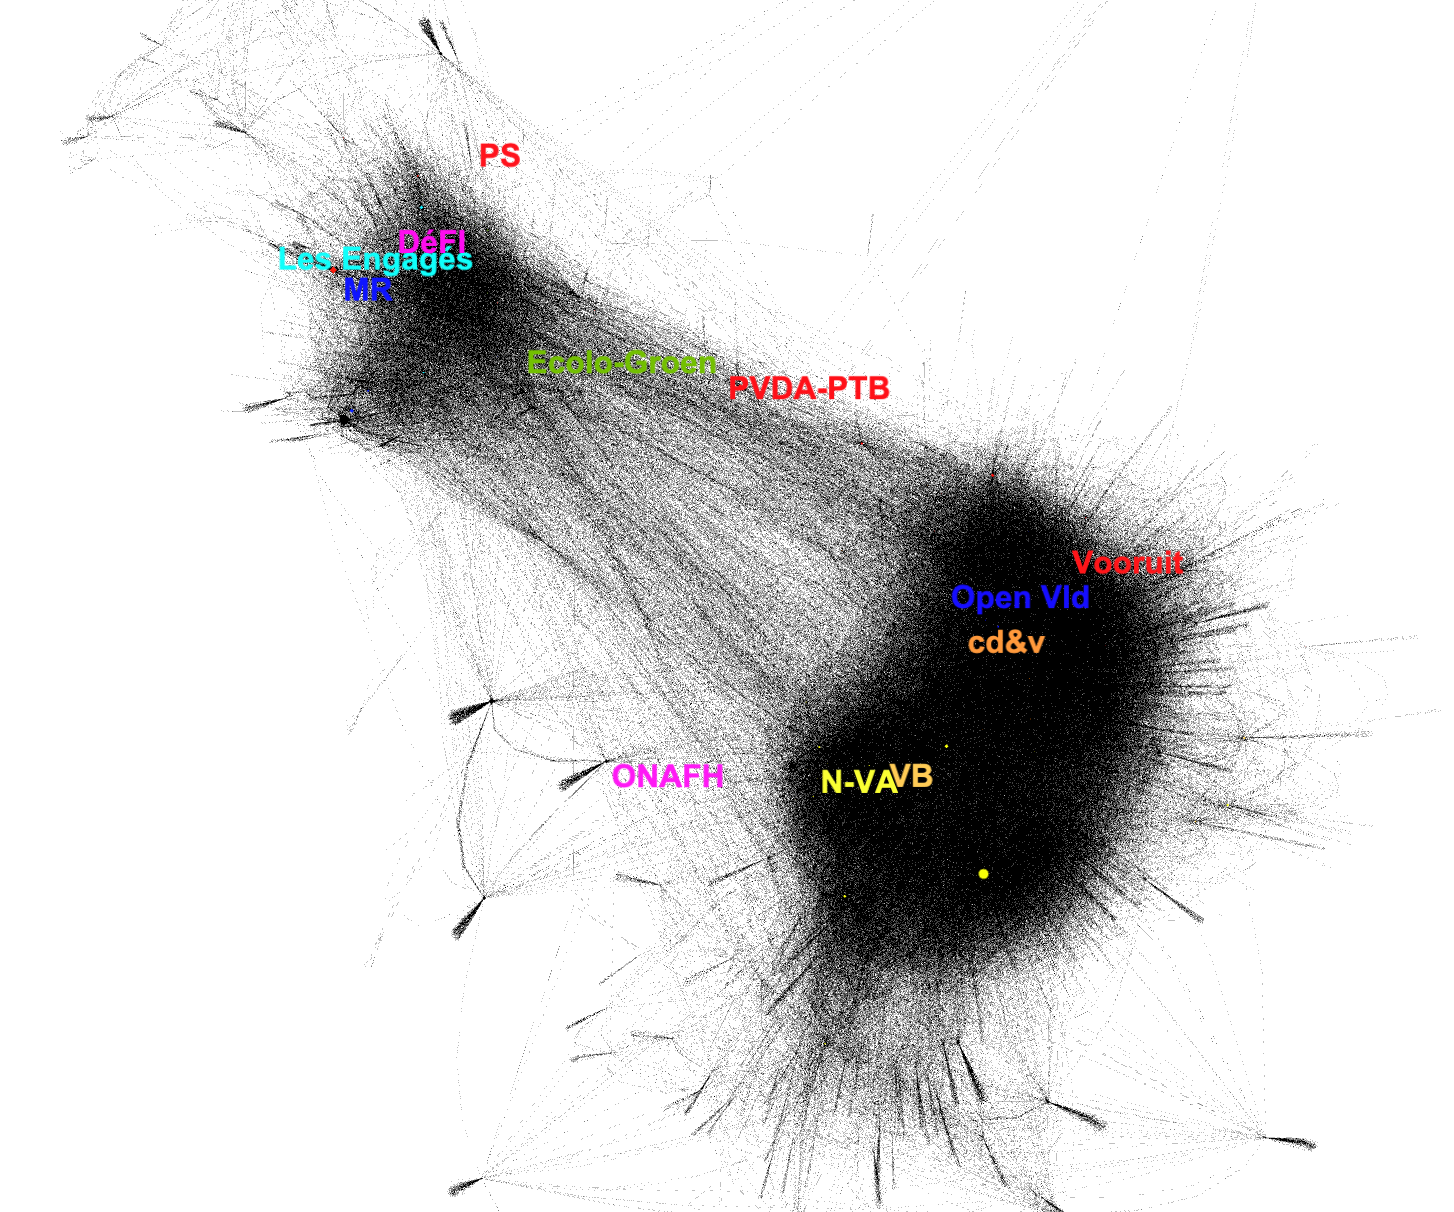

In [9]:
# Focus on the Flemish part
Image(filename='Graph pre data processing.png', width=300, height = 300)

As the previous image shows the graph that represents all the interactions between politicians and other twitter users. We can see that the interactions happen mostly within language communities and that the flemish language community seems to be more active on X, since there are more nodes and edges surrounding the flemish parties. However, the graph is a large hairball graph that only gives little insight and is difficult to analyse. This is partly due to the current graph structure which represents parties, politicians and users as well as tweets as nodes. Since we are not intersted in the content of the tweets but they are merely a tool to create the connection between politician and users in the politician's network we will create new direct edges between politicans and users with the number of interactions as edge weights, which will result in a simplified graph that is easier to analyse and visualize. With the new graph structure the node size (which depends on the number of edges) becomes more meaningful, as it now represents the number of twitter user interacting with a politician and not anymore the number of tweets tweeted by a user. The visual below on the left shows the current graph structure and the visual on the right shows the simplified graph structure we want to end up with.

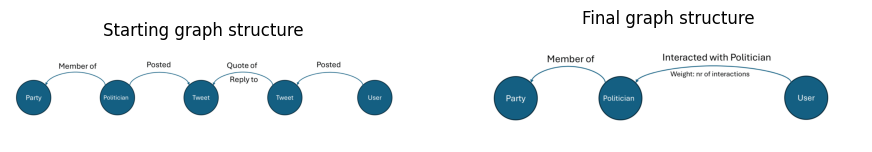

In [10]:
# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

# read images
img_A = mpimg.imread('visual_start-1.png')
img_B = mpimg.imread('visual_final-1.png')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A)
ax[1].imshow(img_B)
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Starting graph structure')
ax[1].set_title('Final graph structure')

plt.show()

We performed some further checks to get a better understanding of the structure of the graph using our previously defined method of printing the edeges of one node. From these checks it becomes clear that some tweets that the politican posted, are replies to their own tweets. These have to be treated differently than replies of regular twitter users to a politician's tweet. 

In [11]:
# id to check edges
id = "338704" #A tweet posted by a politician, which is a reply to a tweet by a twitter user

for source, target, edge_data in graph.edges(data=True):
    if source == id or target == id:
        # Print the edge information
        print(f"Edge: {source} -> {target}, Edge Data: {edge_data}")

print("\nThe politician that posted the tweet:")
id = "358639"
node_data = graph.nodes[id]
print(f"Node ID: {id}, Node Data: {node_data}")

print("\nThe tweet in question:")
id = "338704"
node_data = graph.nodes[id]
print(f"Node ID: {id}, Node Data: {node_data}")

print("\n This is a reply to this tweet:")
id = "338674"
node_data = graph.nodes[id]
print(f"Node ID: {id}, Node Data: {node_data}")


Edge: 358639 -> 338704, Edge Data: {'edge_type': 'POSTED'}
Edge: 338704 -> 338674, Edge Data: {'edge_type': 'REPLY_TO'}

The politician that posted the tweet:
Node ID: 358639, Node Data: {'created_at': '2011-09-02T06:45:44+00:00', 'description': 'Consultant en Aménagement Numérique des Territoires', 'favourites_count': 24502, 'followers_count': 431, 'friends_count': 510, 'ident': '366462579', 'is_blue_verified': False, 'listed_count': 6, 'location': 'Le Val Sait Germain', 'media_count': 59, 'name': 'Eric THIEBAUT', 'normal_followers_count': 431, 'possibly_sensitive': False, 'screen_name': 'ThiebautEric', 'statuses_count': 8281, 'verified': False, 'label': '366462579', 'node_type': 'User', 'User_label': '366462579', 'Party_name': 'PS'}

The tweet in question:
Node ID: 338704, Node Data: {'created_at': '2024-04-29T20:41:06+00:00', 'favorite_count': 4, 'full_text': '@Marc_Doyer @EmmanuelMacron @verity_france Attention @Marc_Doyer dire "vous comprenez le japonais" c\'est pas une menace ? 😂

# Creating a direct edge between a politician's tweet and a user who is not a politician


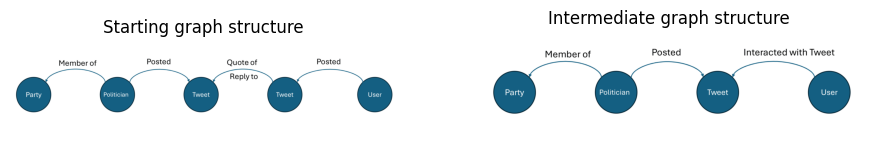

In [12]:
# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

# read images
img_A = mpimg.imread('visual_start-1.png')
img_B = mpimg.imread('visual_intermediate-1.png')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A)
ax[1].imshow(img_B)
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Starting graph structure')
ax[1].set_title('Intermediate graph structure')

plt.show()


 To  create the direct edge between a poltician's tweet and a user who is not a politician who interacted with the tweet, we first search for user tweets. To do that we identify edges that connect politician tweets with user tweets. Those are either 'reply_to' or 'quote_of' edges. Once we have identified a user reply or quote tweet we search all the edges of that tweet to find the 'posted'-edge which links the tweet to the user who posted it. If this user is not a politician we note that a new edge of the edge_type 'interacted_with_tweet' should be created between the politician's tweet and the user. If the user turns out to be a politician, we search the politician's reply tweet for the 'posted_edge' and note that we want to add an edge between the user and the original tweet being replied to. Once all the new edges are found we add them to the graph and remove the edges that linked the users to their reply tweets, as those edges are not necessary anymore. However, deleting these edges results in floating reply tweets without edges. Those nodes are not of use for the following analysis anymore and can be removed.

In [13]:
graph2 = graph.copy()

# Create a list to store edges to remove
edges_to_remove = []
# Create a list to store edges to add
edges_to_add = []

edges = list(graph2.edges(data=True))

# Iterate over the edge list
for source, target, edge_data in edges:
    # Check if the edge represents a reply to a tweet
    if edge_data.get("edge_type") == "REPLY_TO" or edge_data.get("edge_type") == "QUOTE_OF":
        
        reply_tweet_source_id = source # Get the source tweet (i.e. the tweet posted by the user)
        reply_tweet_target_id = target # Get the target tweet (i.e. the tweet posted by the politician)
           
        # Search for edges that end at the reply_tweet node and have edge_type "POSTED"
        for u, v, e_data in graph2.in_edges(reply_tweet_source_id, data=True):
            if e_data.get("edge_type") == "POSTED":

                if 'Party_name' not in graph2.nodes[u]: # The user should not be a politician

                    user_account = u

                    # Add an edge between the user and the original tweet being replied to
                    edges_to_add.append((user_account, reply_tweet_target_id, "INTERACTED_W_TWEET"))
                    
                    # Add edges to remove
                    edges_to_remove.append((reply_tweet_source_id, reply_tweet_target_id))
                    edges_to_remove.append((user_account, reply_tweet_source_id))
                else: # because sometimes the politician replied to the tweet
                    for w, x, e_data2 in graph2.in_edges(reply_tweet_target_id, data=True):

                        if e_data2.get("edge_type") == "POSTED":

                            if 'Party_name' not in graph2.nodes[w]: # The user should not be a politician

                                user_account = w
                                # Add an edge between the user and the original tweet being replied to
                                edges_to_add.append((user_account, reply_tweet_source_id, "INTERACTED_W_TWEET"))
                                
                                # Add edges to remove
                                edges_to_remove.append((reply_tweet_source_id, reply_tweet_target_id))
                                edges_to_remove.append((user_account, reply_tweet_target_id))

# Add new edges
for u, v, edge_type in edges_to_add:
    graph2.add_edge(u, v, edge_type=edge_type)

# Remove edges
graph2.remove_edges_from(edges_to_remove)

nodes_to_remove = []

# Iterate over nodes in graph2
for node, node_data in graph2.nodes(data=True):
    # Check if the node has node_type 'Tweet' and no edges
    if node_data.get('node_type') == 'Tweet' and graph2.degree(node) == 0:
        # Add the node to the list of nodes to remove
        nodes_to_remove.append(node)

# Remove nodes with no edges from graph2
graph2.remove_nodes_from(nodes_to_remove)


## Checks to see if the code works well
### check 1: politician node: should not have the new edge interacted_w_tweet

Successful check! This politican only has several 'posted' edges that link them to tweets and one 'member of' edge that links them to their party.

In [15]:
# id to check edges
id = "345384"

for source, target, edge_data in graph2.edges(data=True):
    if source == id or target == id:
        # Print the edge information
        print(f"Edge: {source} -> {target}, Edge Data: {edge_data}")

Edge: 345384 -> 4688, Edge Data: {'edge_type': 'POSTED'}
Edge: 345384 -> 25149, Edge Data: {'edge_type': 'POSTED'}
Edge: 345384 -> 469337, Edge Data: {'edge_type': 'MEMBER_OF'}
Edge: 345384 -> 25148, Edge Data: {'edge_type': 'POSTED'}
Edge: 345384 -> 25150, Edge Data: {'edge_type': 'POSTED'}
Edge: 345384 -> 25151, Edge Data: {'edge_type': 'POSTED'}
Edge: 345384 -> 25152, Edge Data: {'edge_type': 'POSTED'}
Edge: 345384 -> 25153, Edge Data: {'edge_type': 'POSTED'}
Edge: 345384 -> 25154, Edge Data: {'edge_type': 'POSTED'}
Edge: 345384 -> 25155, Edge Data: {'edge_type': 'POSTED'}
Edge: 345384 -> 25156, Edge Data: {'edge_type': 'POSTED'}
Edge: 345384 -> 25157, Edge Data: {'edge_type': 'POSTED'}
Edge: 345384 -> 25158, Edge Data: {'edge_type': 'POSTED'}
Edge: 345384 -> 25159, Edge Data: {'edge_type': 'POSTED'}
Edge: 345384 -> 25160, Edge Data: {'edge_type': 'POSTED'}
Edge: 345384 -> 70155, Edge Data: {'edge_type': 'POSTED'}
Edge: 345384 -> 70154, Edge Data: {'edge_type': 'POSTED'}
Edge: 34538

### Check 2: tweet node posted by a politican 
Successful check! The tweet has one edge to the politican who tweeted it, edges with users who interacted with it and reply edges when the politican refered to the post.

In [16]:
id="70155"

for source, target, edge_data in graph2.edges(data=True): 
    if source == id or target == id:
        # Print the edge information
        print(f"Edge: {source} -> {target}, Edge Data: {edge_data}")

Edge: 345384 -> 70155, Edge Data: {'edge_type': 'POSTED'}
Edge: 70155 -> 70154, Edge Data: {'edge_type': 'REPLY_TO'}
Edge: 70156 -> 70155, Edge Data: {'edge_type': 'REPLY_TO'}
Edge: 345538 -> 70155, Edge Data: {'edge_type': 'INTERACTED_W_TWEET'}
Edge: 345677 -> 70155, Edge Data: {'edge_type': 'INTERACTED_W_TWEET'}
Edge: 348069 -> 70155, Edge Data: {'edge_type': 'INTERACTED_W_TWEET'}
Edge: 366824 -> 70155, Edge Data: {'edge_type': 'INTERACTED_W_TWEET'}


### Check 3: user node that is not a politican
Check successful! This twitter user only has edges to tweets made by politicians and no more edges to the user's tweets.

In [17]:
# id to check edges
id="352012"

for source, target, edge_data in graph2.edges(data=True): 
    if source == id or target == id:
        # Print the edge information
        print(f"Edge: {source} -> {target}, Edge Data: {edge_data}")

Edge: 352012 -> 22871, Edge Data: {'edge_type': 'INTERACTED_W_TWEET'}
Edge: 352012 -> 59063, Edge Data: {'edge_type': 'INTERACTED_W_TWEET'}
Edge: 352012 -> 74316, Edge Data: {'edge_type': 'INTERACTED_W_TWEET'}
Edge: 352012 -> 84829, Edge Data: {'edge_type': 'INTERACTED_W_TWEET'}
Edge: 352012 -> 151277, Edge Data: {'edge_type': 'INTERACTED_W_TWEET'}
Edge: 352012 -> 151585, Edge Data: {'edge_type': 'INTERACTED_W_TWEET'}
Edge: 352012 -> 180272, Edge Data: {'edge_type': 'INTERACTED_W_TWEET'}
Edge: 352012 -> 188699, Edge Data: {'edge_type': 'INTERACTED_W_TWEET'}
Edge: 352012 -> 237813, Edge Data: {'edge_type': 'INTERACTED_W_TWEET'}
Edge: 352012 -> 256340, Edge Data: {'edge_type': 'INTERACTED_W_TWEET'}
Edge: 352012 -> 282764, Edge Data: {'edge_type': 'INTERACTED_W_TWEET'}
Edge: 352012 -> 304673, Edge Data: {'edge_type': 'INTERACTED_W_TWEET'}
Edge: 352012 -> 312025, Edge Data: {'edge_type': 'INTERACTED_W_TWEET'}
Edge: 352012 -> 326233, Edge Data: {'edge_type': 'INTERACTED_W_TWEET'}
Edge: 3520

These are 50 of the newly created edges as an example of the current graph structure

In [18]:
# Counter to keep track of the number of printed edges
count = 0

# Iterate through the edges to find INTERACTED_WITH edges
for source, target, edge_data in graph2.edges(data=True):
    if edge_data.get("edge_type") == "INTERACTED_W_TWEET":
        print(f"Tweet Politician {target} <-- INTERACTED_W_TWEET -- User_account {source}")
        count += 1
        if count >= 50:
            break

Tweet Politician 4675 <-- INTERACTED_W_TWEET -- User_account 345385
Tweet Politician 258897 <-- INTERACTED_W_TWEET -- User_account 345385
Tweet Politician 258900 <-- INTERACTED_W_TWEET -- User_account 345385
Tweet Politician 4693 <-- INTERACTED_W_TWEET -- User_account 345390
Tweet Politician 16001 <-- INTERACTED_W_TWEET -- User_account 345390
Tweet Politician 16058 <-- INTERACTED_W_TWEET -- User_account 345390
Tweet Politician 25663 <-- INTERACTED_W_TWEET -- User_account 345390
Tweet Politician 40500 <-- INTERACTED_W_TWEET -- User_account 345390
Tweet Politician 62713 <-- INTERACTED_W_TWEET -- User_account 345390
Tweet Politician 73965 <-- INTERACTED_W_TWEET -- User_account 345390
Tweet Politician 103962 <-- INTERACTED_W_TWEET -- User_account 345390
Tweet Politician 108482 <-- INTERACTED_W_TWEET -- User_account 345390
Tweet Politician 140681 <-- INTERACTED_W_TWEET -- User_account 345390
Tweet Politician 152721 <-- INTERACTED_W_TWEET -- User_account 345390
Tweet Politician 183008 <-- IN

Save the intermediate file if you want

In [19]:
# Define the path where you want to save the file
#file_path = "modified_graph_interaction_with_tweet.graphml"

# Save the modified graph in .graphml format
#nx.write_graphml(graph2, file_path)

# Now look at the direct interaction between the politician and the user

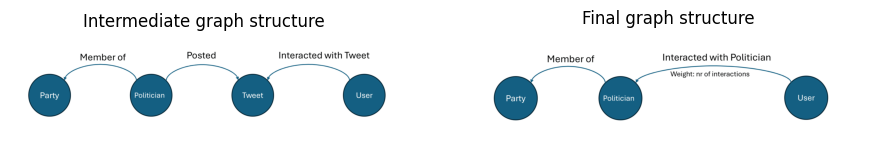

In [20]:
# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

# read images
img_A = mpimg.imread('visual_intermediate-1.png')
img_B = mpimg.imread('visual_final-1.png')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A)
ax[1].imshow(img_B)
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Intermediate graph structure')
ax[1].set_title('Final graph structure')

plt.show()

Right now we have the intermediate graph structure that is displayed on the left, to arrive at the final graph structure on the right we need to create direct edges betwee politicans and user who replied to their tweets.   To implement that we first need to identify the remaining tweets that are user are interacting with. Once we identified a tweet node, we use the 'posted' edge to find the poltician who created the post and note that we want to created an edge between the politican and the user who interacted with tweet. Since there could be more than one interaction between a user and a politician, the edges need to have a new feature 'weight' corresponding to the number of interactions (replies or quotes) that happened between a user and a politican to not loose important information. So instead of automatically creating a new edge, we check whether there is already an edge between that politician and user, if so we increase the weight of that edge, if not we create a new edge.

In [21]:
# Start from graph 2 and make a copy
graph3 = graph2.copy()

# Create a list to store edges to remove
edges_to_remove = []
edges = list(graph3.edges(data=True))

# Iterate over the edge list
for source, target, edge_data in edges:
    if edge_data.get("edge_type") == "INTERACTED_W_TWEET":
        user_account_id = source  # Get the source (i.e. the user account that is not a politician that posted the tweet)
        tweet_id = target  # Get the target (i.e. the tweet that was posted by the politician)

        # Search for edges that end at the tweet node and have edge_type "POSTED"
        for u, v, e_data in graph2.in_edges(tweet_id, data=True):
            if e_data.get("edge_type") == "POSTED":
                politician_account = u  # Then politician_account is the source

                # Add or increment an edge between the user and the politician
                if graph3.has_edge(user_account_id, politician_account):
                    # Increment the weight if the edge already exists
                    if 'weight' in graph3[user_account_id][politician_account]:
                        graph3[user_account_id][politician_account]['weight'] += 1
                    else:
                        graph3[user_account_id][politician_account]['weight'] = 2  # If there's already an edge without weight, initialize to 2
                else:
                    # Add the edge with an initial weight of 1
                    graph3.add_edge(user_account_id, politician_account, edge_type="INTERACTED_W_POLITICIAN", weight=1)

                # Add edges to remove
                edges_to_remove.append((user_account_id, tweet_id))
                edges_to_remove.append((politician_account, tweet_id))

graph3.remove_edges_from(edges_to_remove)

# Remove the loose nodes
nodes_to_remove = []

# Iterate over nodes in graph2
for node, node_data in graph3.nodes(data=True):
    # Check if the node has node_type 'Tweet' and no edges
    if node_data.get('node_type') == 'Tweet' or graph3.degree(node) == 0:
        # Add the node to the list of nodes to remove
        nodes_to_remove.append(node)

# Remove nodes with no edges from graph2
graph3.remove_nodes_from(nodes_to_remove)

## Checks to see if the code works well
### Check 1: politician
#### Check 1.1: whether the edges of a 'politician-node' are correct
Check successful! They should still be a member of a party and then interact with different twitter user accounts and those edges are supposed to have different weights. The only edges that remain are tweets that are posted by the politician as a reply to their own tweets and the party membership.


In [23]:
# id to check edges
id = "351970"

for source, target, edge_data in graph3.edges(data=True):
    if source == id or target == id:
        # Print the edge information
        print(f"Edge: {source} -> {target}, Edge Data: {edge_data}")

Edge: 345390 -> 351970, Edge Data: {'edge_type': 'INTERACTED_W_POLITICIAN', 'weight': 1}
Edge: 351970 -> 469332, Edge Data: {'edge_type': 'MEMBER_OF'}
Edge: 345392 -> 351970, Edge Data: {'edge_type': 'INTERACTED_W_POLITICIAN', 'weight': 1}
Edge: 345399 -> 351970, Edge Data: {'edge_type': 'INTERACTED_W_POLITICIAN', 'weight': 1}
Edge: 345403 -> 351970, Edge Data: {'edge_type': 'INTERACTED_W_POLITICIAN', 'weight': 2}
Edge: 345404 -> 351970, Edge Data: {'edge_type': 'INTERACTED_W_POLITICIAN', 'weight': 1}
Edge: 345414 -> 351970, Edge Data: {'edge_type': 'INTERACTED_W_POLITICIAN', 'weight': 1}
Edge: 345422 -> 351970, Edge Data: {'edge_type': 'INTERACTED_W_POLITICIAN', 'weight': 3}
Edge: 345705 -> 351970, Edge Data: {'edge_type': 'INTERACTED_W_POLITICIAN', 'weight': 2}
Edge: 345710 -> 351970, Edge Data: {'edge_type': 'INTERACTED_W_POLITICIAN', 'weight': 1}
Edge: 345726 -> 351970, Edge Data: {'edge_type': 'INTERACTED_W_POLITICIAN', 'weight': 1}
Edge: 345729 -> 351970, Edge Data: {'edge_type':

#### Check 1.2: whether all polticians are still included 
Check successful! Only one poltician is not included in the final graph anymore because they had no tweets with replies or quotes in the first place

First we count the number of tweeets by each politician and number of politicians based on interactions between politicians and other users which results in 134 politicians

In [24]:
counting_pol_tweets = {}
for source, target, edge_data in graph3.edges(data=True):
    if edge_data.get("edge_type")== 'INTERACTED_W_POLITICIAN':
        if target not in counting_pol_tweets:
            counting_pol_tweets[target] = 1
        counting_pol_tweets[target]  += 1
len(counting_pol_tweets)

134

Then we count the politicians based on party membership (edges between party and politician nodes) which results in 135 politicians

In [25]:
counting_pols = {}
for source, target, edge_data in graph3.edges(data=True):
    if edge_data.get("edge_type")== 'MEMBER_OF':
        if source not in counting_pols:
            counting_pols[source] = 1
        counting_pols[source]  += 1  
len(counting_pols)

135

There is one politician with node ID 360395 that is not included in the list of politicians that have edges with other users.

In [26]:
#find the politician without any interactions
keys_pols = set(counting_pols.keys())
keys_pol_tweets = set(counting_pol_tweets.keys())

no_tweet_pols = keys_pols-keys_pol_tweets
no_tweet_pols

{'360395'}

In the final graph this politician has no interaction with other twitter users in the final graph but in the original graph the politician posted one tweet. However this tweet has no interactions (replies or quotes), so it is correct that it is not present in the final network graph anymore

In [38]:
#check in graph 3 for politician with id = 360395
count = 0
for source, target, edge_data in graph3.edges(data=True):
    for id in no_tweet_pols:
        if source == id or target == id:
            # Print the edge information
            if edge_data.get('edge_type') == "POSTED":
                print(f"Edge: {source} -> {target}, Edge Data: {edge_data}")
                print(f"{source},{graph3.nodes[source]['node_type']}")
                print(f"{target},{graph3.nodes[target]['node_type']}")
                count +=1
               
print(f'edges in final graph: {count}')

# id to check edges
# check for the original graph
count = 0
print(f'\nGraph before removing edges and nodes: ')
for source, target, edge_data in graph.edges(data=True):
    for id in no_tweet_pols:
        if source == id or target == id:
            # Print the edge information
            if edge_data.get('edge_type') == "POSTED":
                print(f"Edge: {source} -> {target}, Edge Data: {edge_data}")
                print(f'{source},{graph.nodes[source]["followers_count"]}')
                print(f'number of replies: {target},{graph.nodes[target]['reply_count']}, number of quotes: {graph.nodes[target]['quote_count']}')
                count +=1


edges in final graph: 0

Graph before removing edges and nodes: 
Edge: 360395 -> 44253, Edge Data: {'edge_type': 'POSTED'}
360395,237
number of replies: 44253,0, number of quotes: 0


### Check 2: a twitter user that is not a politician
Check successful! This edge represents a  direct connection between a politician and a user. The user interacted with only one of the politician's tweets.

In [28]:
# id to check edges
id = "354726" # The user => only has the interacted with tweet edge
for source, target, edge_data in graph3.edges(data=True):
    if source == id or target == id:
        # Print the edge information
        print(f"Edge: {source} -> {target}, Edge Data: {edge_data}")

Edge: 354726 -> 351970, Edge Data: {'edge_type': 'INTERACTED_W_POLITICIAN', 'weight': 1}


In [29]:
# Saving the new graph
#file_path = "final_graph.graphml"

# Save the modified graph in .graphml format
#nx.write_graphml(graph3, file_path)

# Analyse the graph

Now that the graph is created, we will use it to check our hypotheses. As a reminder we are interested in the following hypotheses: <br>
<li>H1: Parties that are close on the left-right spectrum share twitter communities. </li>
<li>H2: Populist or extreme parties have more interaction with other twitter users compared to centrist parties.</li>
<li>H3: There are different communities for the two language communities.</li>

We are using a community mining technique to find clusters in our graph. We use the Louvain-algorithm which is a greedy algorithm and less computaionally intensive than other simple techniques such as the Girvan-Newman or Simple-cut approach. In the first step of the Louvain algorithm each node is its own community and subsequently communities are merged to increase the modularity of the graph. Modularity compares the intra- to inter- community connectivity. The algorithm stops when there are no more possible merges that imporve the modularity. 
In addition to that we define a function that counts the intra and inter community connections of a graph by checking whether the source and target node of an edge have the same community feature. It then returns two dictionaires: in the intra edges dictionairy the keys represent the community and in the inter dictionairy the keys are a touple indicating the communities that are linked.

In [30]:
#function to analyse community inter-intra connectivity
def intra_inter(graph):
    intra = {}
    inter = {}

    for u, v, edge_data in graph.edges(data=True):
        com_node1 = graph.nodes[u]['community']
        com_node2 = graph.nodes[v]['community']
        if edge_data.get('weight'):
            adding = edge_data.get('weight')
        else:
            adding = 1
        if com_node1 == com_node2:
            if com_node1 not in intra:
                intra[com_node1]=adding
            else:
                intra[com_node1]+=adding
        else:
            if (com_node1, com_node2) not in inter:
                if (com_node2, com_node1) not in inter:
                    inter[(com_node1, com_node2)]=adding
                else:
                    inter[(com_node2, com_node1)]+=adding
            else:
                inter[(com_node1, com_node2)]+=adding
        
    return intra, inter

With the default Louvain algorithm we arrive at 11 communities which is close to the number of parties (12) that are taken into account. We then use the louvain-community partition to create a new node feature 'community' that represent the community a node belongs to. After adding this feature we can use the previusly defined function to get more insight into inter and intra connectivity of each community. Now we can use results to count the number of inter-community connections for each community and calculate a ratio between inter and intra edges for each community. <br>
 Some of the communities have more edges to other communities than within edges, indicating a not-ideal partition of the network. Additionally, since we are interested to see whether the communities of different parties overlap, we decide to reduce the resolution feature from the default value of 1 to 0.2. Smaller values for this feature increases the size of the communities and in turn returns smaller but larger communities.

In [31]:
louv_com_initial =nx.community.louvain_communities(graph3, weight='weight', seed=12, resolution=1)
modularity_louv_initial = nx.community.modularity(graph3, louv_com_initial)
print(f'Number of communities: {len(louv_com_initial)} with modularity: {modularity_louv_initial}')

#assiging communities as graph feature
community_nr = 1
for community in louv_com_initial:
    #print(community_nr)
    for node in community:
        #print(node)
        graph3.nodes[node]['community']=community_nr
    community_nr += 1


#using the previously defined function to get inter and intra community edges
intra, inter = intra_inter(graph3)
print(f'intra edges: {intra}')
print(f'inter edgdes:{inter}')

#compare intra-inter edges per community
compare_intra_inter = {}
for community in intra:
    count_inter_edges = 0
    for edges in inter:
        if edges[0] == community or edges[1]== community:
            count_inter_edges += inter[edges]
    ratio = count_inter_edges/intra[community]
    compare_intra_inter[community] = (intra[community], count_inter_edges,ratio)

print('Comparison of inter-intra edges per community: ')
compare_intra_inter

Number of communities: 11 with modularity: 0.5096473597284401
intra edges: {1: 13003, 5: 31499, 3: 19942, 4: 445, 10: 5232, 6: 585, 8: 348, 2: 14393, 7: 950, 9: 971, 11: 5}
inter edgdes:{(3, 1): 437, (2, 1): 6539, (3, 2): 670, (4, 3): 6, (10, 1): 1205, (3, 5): 2147, (8, 1): 221, (6, 5): 721, (8, 5): 243, (3, 9): 308, (5, 1): 7699, (1, 7): 22, (2, 10): 1052, (2, 5): 7687, (2, 8): 108, (2, 6): 324, (6, 1): 469, (2, 7): 25, (6, 3): 33, (10, 5): 758, (10, 8): 8, (8, 3): 29, (5, 7): 117, (6, 7): 3, (3, 7): 92, (3, 10): 235, (5, 9): 52, (10, 6): 26, (8, 6): 14, (8, 7): 2, (10, 7): 9, (9, 10): 3, (1, 9): 5, (7, 9): 7, (4, 5): 3, (9, 2): 2, (11, 3): 1, (8, 9): 1, (4, 7): 4}
Comparison of inter-intra edges per community: 


{1: (13003, 16597, 1.2763977543643774),
 5: (31499, 19427, 0.6167497380869233),
 3: (19942, 3958, 0.1984755791796209),
 4: (445, 13, 0.029213483146067417),
 10: (5232, 3296, 0.6299694189602446),
 6: (585, 1590, 2.717948717948718),
 8: (348, 626, 1.7988505747126438),
 2: (14393, 16407, 1.13992913221705),
 7: (950, 281, 0.29578947368421055),
 9: (971, 378, 0.38928939237899074),
 11: (5, 1, 0.2)}

With the reduced resolutin we arrive at four communities. We use the same approach as before where we assign the community numbers as a feature to the nodes, use the predefined function to count inter and intra-community connectivity and the calculate the ratio between those two. This results in two large communities, one medium sized and one small community. All of them have more intra than inter connections. Especially in community 3 there is about 30 times more intra community communication. 

In [32]:
louv_com =nx.community.louvain_communities(graph3, weight='weight', seed=12, resolution=0.2)
modularity_louv = nx.community.modularity(graph3, louv_com)
print(f'Number of communities: {len(louv_com)} with modularity: {modularity_louv}')

#assiging communities as graph feature
community_nr = 1
for community in louv_com:
    #print(community_nr)
    for node in community:
        #print(node)
        graph3.nodes[node]['community']=community_nr
    community_nr += 1

#using the previously defined function to get inter and intra community edges
intra, inter = intra_inter(graph3)
print(f'intra edges: {intra}')
print(f'inter edgdes:{inter}')

#compare intra-inter edges per community
compare_intra_inter = {}
for community in intra:
    count_inter_edges = 0
    for edges in inter:
        if edges[0] == community or edges[1]== community:
            count_inter_edges += inter[edges]
    ratio = count_inter_edges/intra[community]
    compare_intra_inter[community] = (intra[community], count_inter_edges,ratio)

print('Comparison of inter-intra edges per community: ')
compare_intra_inter

Number of communities: 4 with modularity: 0.289762147835503
intra edges: {3: 93908, 1: 21184, 2: 445, 4: 5}
inter edgdes:{(1, 3): 3104, (2, 1): 10, (2, 3): 3, (4, 3): 1}
Comparison of inter-intra edges per community: 


{3: (93908, 3108, 0.033096221834135534),
 1: (21184, 3114, 0.1469977341389728),
 2: (445, 13, 0.029213483146067417),
 4: (5, 1, 0.2)}

To further analyse the communities we check which party belongs to which community by checking the community feature of each party node. The two large communities represent the language communities. All the flemish parties are in community three and all the francophone parties are in community one. None of the parties belong to community 2 or 4 so further analysis for these two communities is needed.

In [33]:
#checking which party node is in which community
for node, node_data in graph3.nodes(data=True):
    if node_data.get('node_type')== 'Party':
        print(f'{node_data.get('ident')} belongs to community {node_data.get('community')}')

N-VA belongs to community 3
Open Vld belongs to community 3
Les Engagés belongs to community 1
DéFI belongs to community 1
VB belongs to community 3
PS belongs to community 1
Ecolo-Groen belongs to community 3
PVDA-PTB belongs to community 3
MR belongs to community 1
cd&v belongs to community 3
Vooruit belongs to community 3
ONAFH belongs to community 1


So we decided to check which politicans are in the small communities 2 and 4 using the node features 'party_name' to identify a poltician and 'community' to select the corresponding communities. The small communities 2 and 4  represent 3 individual polticians who belong to neither party.

In [34]:
for node, node_data in graph3.nodes(data=True):
    if node_data.get('Party_name') and node_data.get('community') == 2 or node_data.get('community') == 4:
        print(f'Politician: {node_data.get('name')} of party {node_data.get('party_name')}belongs to community {node_data.get('community')}')

Politician: Eric THIEBAUT of party Nonebelongs to community 2
Politician: Chanson julie of party Nonebelongs to community 4
Politician: Romain Chanson of party Nonebelongs to community 4


# Final Discussion
Below you can see the final graph that only includes direct interactions between parties, polticians and users and no more tweets visualized using gephi. Additionally, the communities are indicated. We can see that the parties are separted based on the language communities confirming hypothesis 3. Additionally, we can observe that the twitter audiances of parties overlap according to the left-right placement of parties confirming hypohesis 1. However, the left-right placement is based rather on cultural left-right spectrum than on an economic spectrum. As you can see when comparing the network graph with the info graphic provided by the university of Antwerp. For example, while both Open-VLD and cd&v are located more on the right economic spectrum, in the network graph cd&v is closer to N-VA and VB, because they are closer on the cultural right-left spectrum than open-VLD.

The separate community in the top-right is based on the N-VA politician Darya Safai who posted a tweet in english which resulted in a lot of international reactions of users that normally do not interact with accounts of belgian politicians.

Finally, the two biggest nodes, hence the politicians with the most interaction are Theo Francken and Darya Safai who are both part of N-VA which can be considered as a populist party. Hence, confirming hypothesis 2, that populist parties have more user engagement on social media platforms.

(source: https://www.gva.be/cnt/dmf20240521_91914270 and https://www.nieuwsblad.be/cnt/dmf20240521_96158280 )

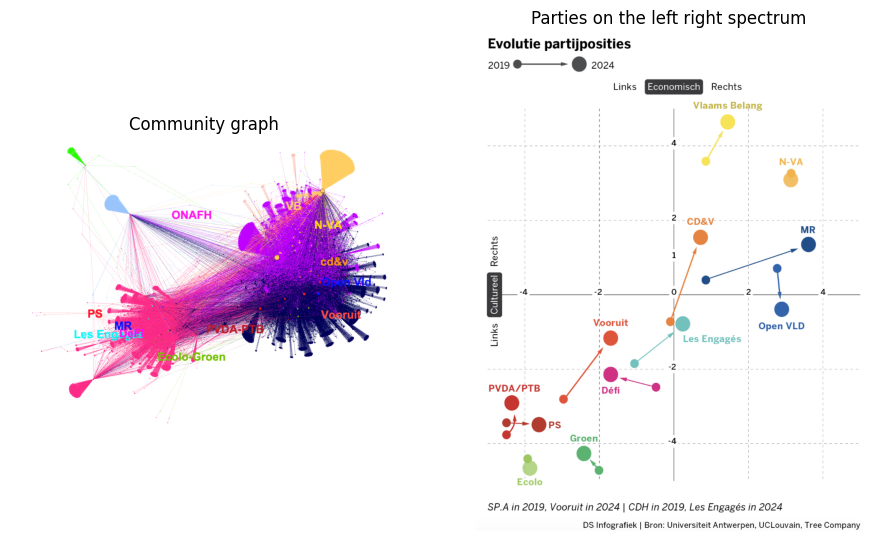

In [35]:
# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

# read images
img_A = mpimg.imread('Community graph.png')
img_B = mpimg.imread('Political_Parties_Belgium.png')

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A)
ax[1].imshow(img_B)
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Community graph')
ax[1].set_title('Parties on the left right spectrum')

plt.show()

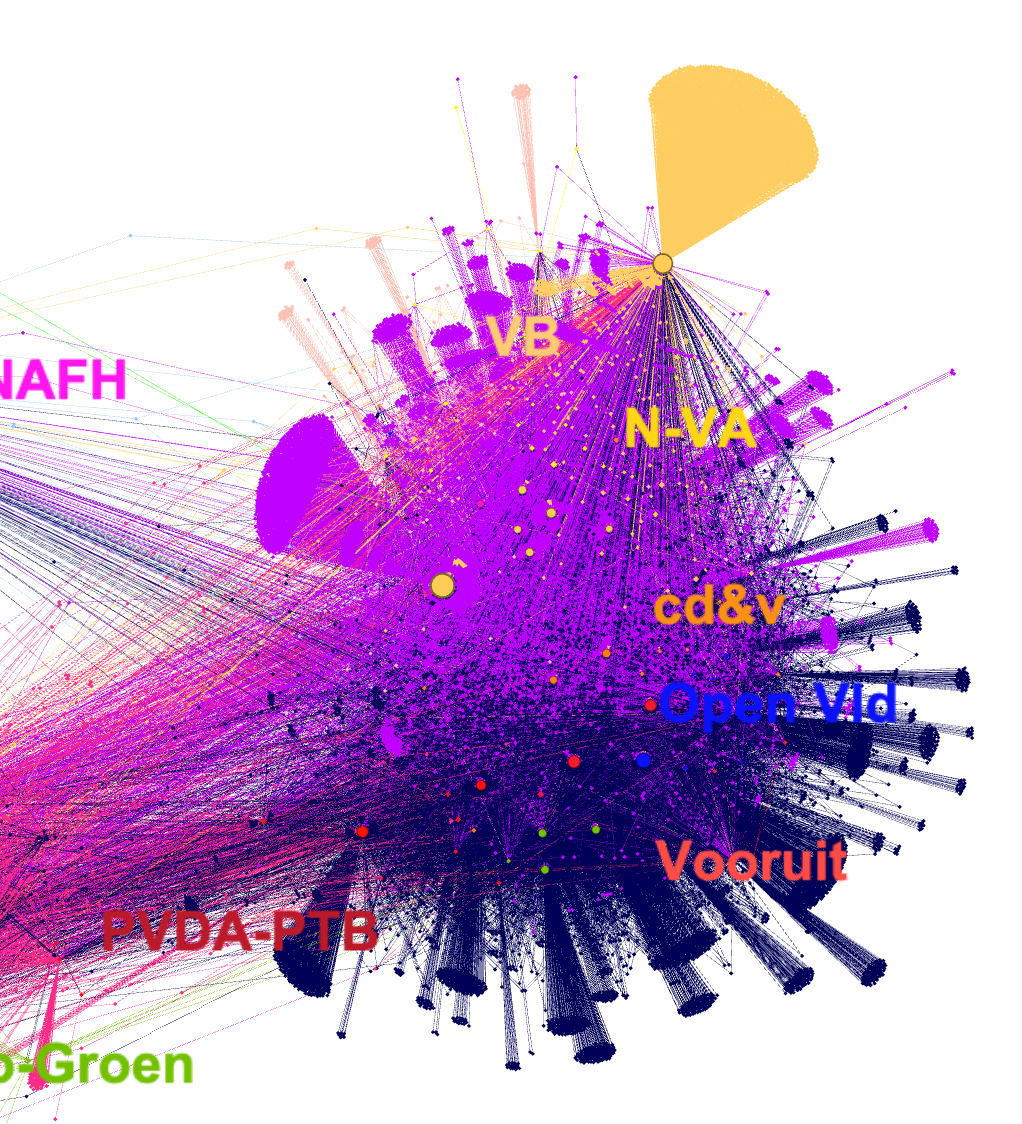

In [36]:
# Focus on Flanders
Image(filename='Zoom Flanders.png', width=250, height = 250)